In [1]:
import os

import numpy as np
import cv2
import re  # for string splitting
import h5py

from scipy import signal
from droplets import do_cutouts
from droplets import do_metrics
from ipywidgets import interact, interactive, fixed, interact_manual

import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy.random as random
import scipy.stats as stats
import matplotlib.cm as cm
import matplotlib.patches as patches

from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator


import gc
# %matplotlib

In [2]:
def read_hdf5(path, filename):
    f = h5py.File('{0}/{1}'.format(path, filename), 'r')
    return f['data']['time'], f['data']['Tave']


# These are the sizes that are in the folder of hdf5 files. Must have the same timesteps
sizes = [3, 5, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

# sizes is the x
x = sizes

# y is the timesteps, and this is taken from the file t_calib_22.h5
time, _ = read_hdf5(
    '/Users/olofjonsson/Projects/Ice/Analysis/From_Niloo/Temp_sim_Jan2010', 't_calib_22.h5')
y = list(time[:])

# Create an empy matrix with the size of the sizes and times
temperatures = np.zeros([len(x), len(y)])

# Filling the matrix with actual values measured.
for size_index, size_value in enumerate(sizes):
    _, temperatures[size_index] = read_hdf5(
        '/Users/olofjonsson/Projects/Ice/Analysis/From_Niloo/Temp_sim_Jan2010', 't_calib_{0}.h5'.format(size_value))

# This is a function returned by the RegularGridInterpolator
#interpolate_T = interp2d(xx, yy, temperatures, kind='linear',bounds_error=True)
interpolate_T = RegularGridInterpolator((x, y), temperatures)

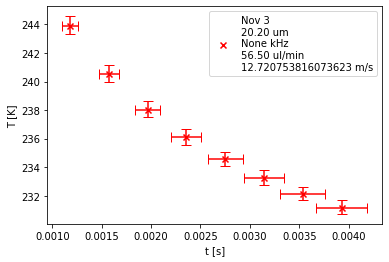

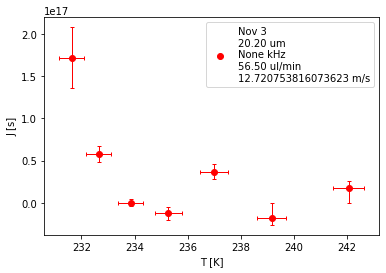

In [3]:
'''class MeasuredPoint(object):
    def __init__(self,distance,count,fraction,parent_series):
        self.distance=distance
        self.count=count
        self.fraction=fraction
        
class Calculated_point(object):
    def __init__(self,distance,time,T,J):
        self.distance=distance
        self.count=count
        self.fraction=fraction
'''


class Series(object):
    _counter = 0  # Number of Series we have

    def __init__(self,
                 date_string=None,
                 T_function=None,
                 d_value=None,
                 d_sigma=None,
                 s_value=None,
                 s_sigma=None,
                 q_value=None):

        Series._counter += 1  # increase the count by one
        self.id = Series._counter  # Id of this series

        self.date = date_string
        # self.measured_points=[]
        # self.calculated_points=[]
        self.descriptor = date_string
        self.T_function = T_function

        # descriptors for drops
        self.d_value = d_value
        self.d_sigma = d_sigma
        self.s_value = s_value
        self.s_sigma = s_sigma
        self.q_value = q_value

    def calculate_t(self, distance, d, q, s):
        '''
        calculate_t(distance, d, q, s)
        use 

        l in m
        d in m
        q in microliters/s
        s in m
        '''

        d_um = d*1e6
        # l_mm=l*1e3
        q_m3_per_s = q*1.666666e-11
        # s_um=s*1e6

        #print(str(l) + ' m distance')
        #print(str(l_mm) + ' mm distance')
        #print(str(d) + ' m diameter')
        #print(str(d_um) + ' um diameter')
        #print(str(s) + ' m spacing')
        #print(str(s_um) + ' um spacing')
        #print(str(q_m3_per_s) + ' flow rate in m^3/s')

        t = np.divide(distance*np.pi*d*d*d, 6*q_m3_per_s*s)
        return t

    def calculate_v(self, d, q, s):
        '''
        calculate_v(d, q, s)
        use 

        d in m
        q in microliters/s
        s in m
        '''

        d_um = d*1e6
        # l_mm=l*1e3
        q_m3_per_s = q*1.666666e-11
        # s_um=s*1e6

        #print(str(d) + ' m diameter')
        #print(str(d_um) + ' um diameter')
        #print(str(s) + ' m spacing')
        #print(str(s_um) + ' um spacing')
        #print(str(q_m3_per_s) + ' flow rate in m^3/s')

        v = np.divide(6*q_m3_per_s*s, np.pi*d*d*d)
        return v

    def calculate_T(self, t, d):
        '''
        input is time and diameter, output is temperature. 

        please use 

        d in m
        t in s
        T_function is the interpolation function to use
        '''
        try:
            T = self.T_function([d*1e6, t], method='linear')[0]
        except:
            #print('{0} {1}'.format(t,d*1e6))
            T = np.nan
        return T

    def calculate_J(self, q, s, d, l_1, l_2, f_1, f_2):
        '''
        input is observables, output is J in unit of 1/(s m^3). 

        please use 

        q in microliters/s
        s in m
        d in m
        l in m
        f as fraction

        we will calculate at length l_1 with fraction f_2
        '''

        q_m3_per_s = q*1.666666e-11

        the_log = np.log(np.divide(np.subtract(1, f_2), np.subtract(1, f_1)))
        factor = np.divide((-36*np.multiply(q_m3_per_s, s)),
                           (np.multiply(np.power(np.pi, 2), np.power(d, 6))))

        J = np.divide(np.multiply(factor, the_log), np.subtract(l_2, l_1))

        return J

    def testing(self):
        print('testing runs')

    def set_observables(self,
                        frequency=None,
                        d_value=None,
                        d_sigma=None,
                        s_value=None,
                        s_sigma=None,
                        q_value=None,
                        distances=None,
                        counts=None,
                        fractions=None):

        assert len(set(map(len, (distances, counts, fractions)))
                   ) == 1, "Lists must have equal length"

        self.d_value = d_value
        self.d_sigma = d_sigma
        self.s_value = s_value
        self.s_sigma = s_sigma
        self.q_value = q_value
        self.frequency = frequency

        self.ideal_t_at_measured = []
        self.ideal_t_at_calculated = []
        self.measured_distances = []

        self.ideal_v = self.calculate_v(d_value, q_value, s_value)

        for distance_i, distance in enumerate(distances):
            # set measured distances
            self.measured_distances.append(distance)
            # calculate t at those
            self.ideal_t_at_measured.append(self.calculate_t(
                distance, self.d_value, self.q_value, self.s_value))

            self.counts = counts
            self.fractions = fractions

        # calculate mid-point distances and calculate t at those
        calculated_distances = np.convolve(distances, [1, 1], 'valid') / 2
        self.calculated_distances = calculated_distances
        self.ideal_t_at_calculated = [self.calculate_t(
            distance, self.d_value, self.q_value, self.s_value) for distance in calculated_distances]

        # calculate ideal T:

        # print(self.d_value)
        # print(self.ideal_t_at_measured)
        self.ideal_T_at_measured = [self.calculate_T(
            t, self.d_value) for t in self.ideal_t_at_measured]

        # print(self.ideal_t_at_calculated)

        self.ideal_T_at_calculated = [self.calculate_T(
            t, self.d_value) for t in self.ideal_t_at_calculated]

        # calculate ideal J:
        self.ideal_J = [self.calculate_J(self.q_value,
                                         self.s_value,
                                         self.d_value,
                                         self.measured_distances[i+1],
                                         self.measured_distances[i],
                                         self.fractions[i+1],
                                         self.fractions[i]) for i in range(len(self.calculated_distances))]

    def calculate_errors(self, percentile=5, trials=1000, do_J=False):
        # for the matrix varibles:

        self.trials = trials

        assert percentile > 0 and percentile <= 50, "percentile must be >0 and <=50"
        self.percentiles = (percentile, 100-percentile)

        self.run_MC_for_only_T(trials)

        # high and low limits
        self.low_T_at_measured = np.percentile(
            self.T_MC_matrix_at_measured, q=percentile, axis=0)
        self.high_T_at_measured = np.percentile(
            self.T_MC_matrix_at_measured, q=100-percentile, axis=0)
        # errors for plotting
        self.low_T_err_at_measured = np.subtract(
            self.ideal_T_at_measured, self.low_T_at_measured)
        self.high_T_err_at_measured = np.subtract(
            self.high_T_at_measured, self.ideal_T_at_measured)

        # high and low limits
        self.low_t_at_measured = np.percentile(
            self.t_MC_matrix_at_measured, q=percentile, axis=0)
        self.high_t_at_measured = np.percentile(
            self.t_MC_matrix_at_measured, q=100-percentile, axis=0)
        # errors for plotting
        self.low_t_err_at_measured = np.subtract(
            self.ideal_t_at_measured, self.low_t_at_measured)
        self.high_t_err_at_measured = np.subtract(
            self.high_t_at_measured, self.ideal_t_at_measured)

        # high and low limits
        self.low_v_at_measured = np.percentile(
            self.v_MC_matrix_at_measured, q=percentile, axis=0)
        self.high_v_at_measured = np.percentile(
            self.v_MC_matrix_at_measured, q=100-percentile, axis=0)
        # errors for plotting
        self.low_v_err_at_measured = np.subtract(
            self.ideal_v, self.low_v_at_measured)
        self.high_v_err_at_measured = np.subtract(
            self.high_v_at_measured, self.ideal_v)

        if do_J:
            self.run_MC_for_J(trials)

            # high and low limits
            self.low_J = np.percentile(self.J_MC_matrix, q=percentile, axis=0)
            self.high_J = np.percentile(
                self.J_MC_matrix, q=100-percentile, axis=0)
            # errors for plotting
            self.low_J_err = np.subtract(self.ideal_J, self.low_J)
            self.high_J_err = np.subtract(self.high_J, self.ideal_J)

            # high and low limits
            self.low_T = np.percentile(self.T_MC_matrix, q=percentile, axis=0)
            self.high_T = np.percentile(
                self.T_MC_matrix, q=100-percentile, axis=0)
            # errors for plotting
            self.low_T_err = np.subtract(
                self.ideal_T_at_calculated, self.low_T)
            self.high_T_err = np.subtract(
                self.high_T, self.ideal_T_at_calculated)

            # high and low limits
            self.low_t = np.percentile(self.t_MC_matrix, q=percentile, axis=0)
            self.high_t = np.percentile(
                self.t_MC_matrix, q=100-percentile, axis=0)
            # errors for plotting
            self.low_t_err = np.subtract(
                self.ideal_t_at_calculated, self.low_t)
            self.high_t_err = np.subtract(
                self.high_t, self.ideal_t_at_calculated)

            # high and low limits
            self.low_v = np.percentile(self.v_MC_matrix, q=percentile, axis=0)
            self.high_v = np.percentile(
                self.v_MC_matrix, q=100-percentile, axis=0)
            # errors for plotting
            self.low_v_err = np.subtract(self.ideal_v, self.low_v)
            self.high_v_err = np.subtract(self.high_v, self.ideal_v)

    def run_MC_for_only_T(self, trials=1000):
        '''        
        In each trial, A value is sampled for q,d and s

        t and T errors can then be calculated for all points

        Then arrays for t and T are calculated

        '''

        self.number_of_trials_only_T = trials

        len_calculated = len(self.measured_distances)

        self.t_MC_matrix_at_measured = np.zeros([trials, len_calculated])
        self.T_MC_matrix_at_measured = np.zeros([trials, len_calculated])
        self.v_MC_matrix_at_measured = np.zeros([trials, len_calculated])

        self.distances_matrix_at_measured = np.zeros([trials, len_calculated])

        for trial in range(trials):

            trial_q = self.q_value
            trial_d = np.random.normal(loc=self.d_value, scale=self.d_sigma)
            trial_s = np.random.normal(loc=self.s_value, scale=self.s_sigma)

            trial_t_array = [self.calculate_t(self.measured_distances[i],
                                              trial_d,
                                              trial_q,
                                              trial_s) for i in range(len_calculated)]

            trial_v_array = [self.calculate_v(
                trial_d, trial_q, trial_s) for i in range(len_calculated)]

            trial_T_array = [self.calculate_T(
                trial_t_array[i], trial_d) for i in range(len_calculated)]

            self.t_MC_matrix_at_measured[trial, :] = trial_t_array
            self.T_MC_matrix_at_measured[trial, :] = trial_T_array
            self.v_MC_matrix_at_measured[trial, :] = trial_v_array

            self.distances_matrix_at_measured[...] = self.measured_distances

    def run_MC_for_J(self, trials=1000):
        '''        
        In each trial, A value is sampled for q,d and s

        t and T errors can then be calculated for all points

        Then arrays for t,T and J are calculated

        '''

        self.number_of_trials = trials

        len_calculated = len(self.calculated_distances)

        self.J_MC_matrix = np.zeros([trials, len_calculated])
        self.t_MC_matrix = np.zeros([trials, len_calculated])
        self.T_MC_matrix = np.zeros([trials, len_calculated])
        self.v_MC_matrix = np.zeros([trials, len_calculated])
        self.distances_matrix = np.zeros([trials, len_calculated])

        for trial in range(trials):

            trial_q = self.q_value
            trial_d = np.random.normal(loc=self.d_value, scale=self.d_sigma)
            trial_s = np.random.normal(loc=self.s_value, scale=self.s_sigma)

            trial_f_array = [np.divide(np.random.binomial(
                self.counts[i], self.fractions[i]), self.counts[i]) for i in range(len(self.counts))]

            trial_t_array = [self.calculate_t(self.calculated_distances[i],
                                              trial_d,
                                              trial_q,
                                              trial_s) for i in range(len_calculated)]

            trial_v_array = [self.calculate_v(
                trial_d, trial_q, trial_s) for i in range(len_calculated)]

            trial_T_array = [self.calculate_T(
                trial_t_array[i], trial_d) for i in range(len_calculated)]

            trial_J_array = [self.calculate_J(trial_q,
                                              trial_s,
                                              trial_d,
                                              self.measured_distances[i+1],
                                              self.measured_distances[i],
                                              trial_f_array[i+1],
                                              trial_f_array[i]) for i in range(len_calculated)]

            self.J_MC_matrix[trial, :] = trial_J_array
            self.t_MC_matrix[trial, :] = trial_t_array
            self.T_MC_matrix[trial, :] = trial_T_array
            self.v_MC_matrix[trial, :] = trial_v_array

            self.distances_matrix[...] = self.calculated_distances

    def generate_plotting_label(self):
        self.plot_label = '{0}\n{1:.2f} um\n{2} kHz\n{3:.2f} ul/min\n{4} m/s'.format(self.date, self.d_value*1e6,
                                                                                     self.frequency, self.q_value, self.ideal_v)

    def save_column_file(self):

        description_line = ' '.join(['Distance',
                                     'Time',
                                     'Time_err_low',
                                     'Time_err_high',
                                     'Temperature',
                                     'Temperature_err_low',
                                     'Temperature_err_high',
                                     'J',
                                     'J_err_low',
                                     'J_err_high'])

        data = np.column_stack((self.calculated_distances,
                                np.array(self.ideal_t_at_calculated),
                                self.low_t_err,
                                self.high_t_err,
                                np.array(self.ideal_T_at_calculated),
                                self.low_T_err,
                                self.high_T_err,
                                np.array(self.ideal_J),
                                self.low_J_err,
                                self.high_J_err))

        np.savetxt(self.date + '_interpolatedpos.txt', data,
                   header=description_line, fmt='%.4e')

        description_line = ' '.join(['Distance',
                                     'Time',
                                     'Time_err_low',
                                     'Time_err_high',
                                     'Temperature',
                                     'Temperature_err_low',
                                     'Temperature_err_high'])

        data = np.column_stack((self.measured_distances,
                                np.array(self.ideal_t_at_measured),
                                self.low_t_err_at_measured,
                                self.high_t_err_at_measured,
                                np.array(self.ideal_T_at_measured),
                                self.low_T_err_at_measured,
                                self.high_T_err_at_measured))

        np.savetxt(self.date + '_measuredpos.txt', data,
                   header=description_line, fmt='%.4e')

    def plot_measured_T_vs_t(self, ax=None, **kwargs):
        if ax == None:
            plt.figure()
            ax = plt.gca()
        xerr = np.array([self.low_t_err_at_measured,
                         self.high_t_err_at_measured])
        yerr = np.array([self.low_T_err_at_measured,
                         self.high_T_err_at_measured])
        ax.scatter(self.ideal_t_at_measured,
                   self.ideal_T_at_measured,
                   marker='x',
                   **kwargs)
        kwargs['label'] = None
        ax.errorbar(self.ideal_t_at_measured,
                    self.ideal_T_at_measured,
                    xerr=xerr,
                    yerr=yerr,
                    fmt='none',
                    capsize=5,
                    **kwargs)

    def plot_T_vs_measured_distance(self, ax=None, **kwargs):
        if ax == None:
            plt.figure()
            ax = plt.gca()
        yerr = np.array([self.low_T_err_at_measured,
                         self.high_T_err_at_measured])
        ax.scatter(self.measured_distances,
                   self.ideal_T_at_measured,
                   marker='x',
                   **kwargs)
        kwargs['label'] = None
        ax.errorbar(self.measured_distances,
                    self.ideal_T_at_measured,
                    yerr=yerr,
                    fmt='none',
                    capsize=5,
                    **kwargs)

    def plot_calculated_T_vs_t(self, ax=None, **kwargs):
        if ax == None:
            plt.figure()
            ax = plt.gca()
        xerr = np.array([self.low_t_err, self.high_t_err])
        yerr = np.array([self.low_T_err, self.high_T_err])

        ax.scatter(self.ideal_t_at_calculated,
                   self.ideal_T_at_calculated,
                   marker='x',
                   **kwargs)
        kwargs['label'] = None
        ax.errorbar(self.ideal_t_at_calculated,
                    self.ideal_T_at_calculated,
                    xerr=xerr,
                    yerr=yerr,
                    fmt='none',
                    capsize=5,
                    **kwargs)

    def plot_J_vs_T(self, ax=None, **kwargs):
        if ax == None:
            plt.figure()
            ax = plt.gca()
        xerr = np.array([self.low_T_err, self.high_T_err])
        yerr = np.array([self.low_J_err, self.high_J_err])

        ax.scatter(self.ideal_T_at_calculated,
                   self.ideal_J,
                   **kwargs)
        kwargs['label'] = None
        ax.errorbar(self.ideal_T_at_calculated,
                    self.ideal_J,
                    xerr=xerr,
                    yerr=yerr,
                    fmt='none',
                    capsize=2, lw=1,
                    **kwargs)

    def plot_J_vs_distance(self, ax=None, **kwargs):
        if ax == None:
            plt.figure()
            ax = plt.gca()
        yerr = np.array([self.low_J_err, self.high_J_err])

        ax.scatter(self.calculated_distances,
                   self.ideal_J,
                   **kwargs)
        kwargs['label'] = None
        ax.errorbar(self.calculated_distances,
                    self.ideal_J,
                    yerr=yerr,
                    fmt='none',
                    capsize=5,
                    **kwargs)


nov_series = Series('Nov 3', interpolate_T)
# CHECK RAW DATA     
counts = np.multiply([48, 27, 34, 210, 715, 881, 797, 84], 1)
fractions = [0, 0.03, 0.00, 0.06, 0.04, 0.04,
             0.13, 0.35]  # ice fraction for focused
distances = np.multiply([15, 20, 25, 30, 35, 40, 45, 50], 0.001)  # in m

nov_series.set_observables(d_value=20.2e-6,
                           d_sigma=0.496e-6,
                           s_value=58.3e-6,
                           s_sigma=3.67e-6,
                           q_value=56.5,
                           distances=distances,
                           counts=counts,
                           fractions=fractions)


# print(nov_series.id)
# print(nov_series.descriptor)
# print(nov_series.ideal_t_at_measured)
# print(nov_series.ideal_t_at_calculated)
# print(nov_series.ideal_T_at_calculated)

# print(nov_series.ideal_J)

# print(nov_series.measured_distances)
# print(nov_series.calculated_distances)

nov_series.calculate_errors(percentile=25, do_J=True)

plt.figure()
ax = plt.gca()
# plt.scatter(nov_series.T_MC_matrix.flatten(),nov_series.J_MC_matrix.flatten(),alpha=1,marker='.')

nov_series.generate_plotting_label()
nov_series.plot_measured_T_vs_t(c='red', label=nov_series.plot_label, ax=ax)
ax.set_xlabel('t [s]')
ax.set_ylabel('T [K]')
# print(nov_series.ideal_v)
plt.legend()
# nov_series.plot_calculated_T_vs_t(ax=ax,c='red')


plt.figure('J_plot')
J_ax = plt.gca()
# plt.scatter(nov_series.T_MC_matrix.flatten(),nov_series.J_MC_matrix.flatten(),alpha=1,marker='.')

nov_series.generate_plotting_label()
nov_series.plot_J_vs_T(c='red', label=nov_series.plot_label, ax=J_ax)
J_ax.set_ylabel('J [s]')
J_ax.set_xlabel('T [K]')
# print(nov_series.ideal_v)
plt.legend()

nov_series.save_column_file()

In [4]:
# type(nov_series.data[1])
# np.savetxt('test.txt',nov_series.data)
#nov_series.data

<ipython-input-3-1bbd8592ff3f>:128: RuntimeWarning: divide by zero encountered in true_divide
  the_log = np.log(np.divide(np.subtract(1, f_2), np.subtract(1, f_1)))
<ipython-input-3-1bbd8592ff3f>:128: RuntimeWarning: invalid value encountered in true_divide
  the_log = np.log(np.divide(np.subtract(1, f_2), np.subtract(1, f_1)))


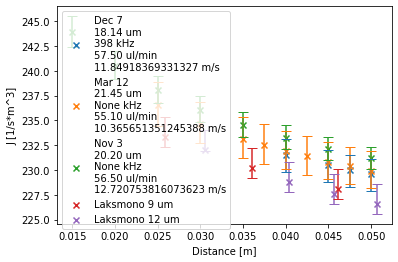

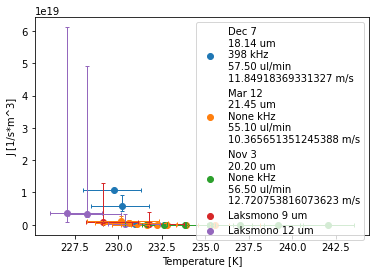

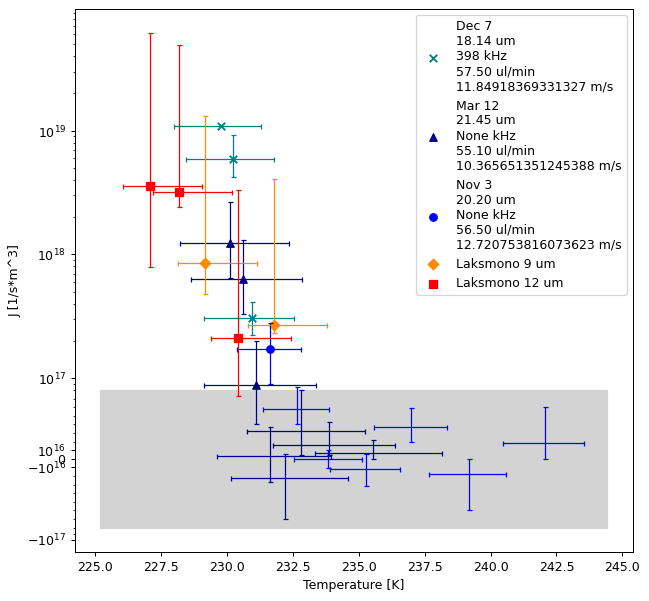

In [8]:


dec7 = Series('Dec 7', interpolate_T)
counts = np.multiply([633, 566, 298, 325], 1)
fractions = [0.0458, 0.362, 0.987, 0.99999]  # ice fraction for focused
distances = np.multiply([40, 45, 47.5, 50], 0.001)  # in m

dec7.set_observables(frequency=398,
                     d_value=18.145e-6,
                     d_sigma=0.409e-6,
                     s_value=38.676e-6,
                     s_sigma=4.063e-6,
                     q_value=57.5,
                     distances=distances,
                     counts=counts,
                     fractions=fractions)


# This is with the last half cutout, when the pressure dropped.
nov3 = Series('Nov 3', interpolate_T)

counts = np.multiply([48, 27, 34, 210, 715, 881, 797, 84], 1)
fractions = [0, 0.03, 0.00, 0.06, 0.04, 0.04,
             0.13, 0.35]  # ice fraction for focused
distances = np.multiply([15, 20, 25, 30, 35, 40, 45, 50], 0.001)  # in m

nov3.set_observables(d_value=20.2e-6,
                     d_sigma=0.496e-6,
                     s_value=58.3e-6,
                     s_sigma=3.67e-6,
                     q_value=56.5,
                     distances=distances,
                     counts=counts,
                     fractions=fractions)


'''
Data from https://docs.google.com/spreadsheets/d/11-GYikog0r1H5IH8vmNHlBlmi4fgEX_WUqMD0C2dIpY/edit#gid=0
and from https://docs.google.com/spreadsheets/d/1VOADjIf649fGTbqI5R4Td48dqzSHE5dx0zcEj2TWAcc/edit#gid=2063575402
'''
mar12 = Series('Mar 12', interpolate_T)
counts = np.multiply([158, 113, 471, 319, 406, 327, 454, 206, 220], 1)
fractions = [0, 0.01769911504, 0.05732484076, 0.09404388715, 0.06896551724,
             0.07339449541, 0.1696035242, 0.6213592233, 0.9181818182]  # ice fraction for focused
distances = np.multiply(
    [25, 30, 35, 37.5, 40, 42.5, 45, 47.5, 50], 0.001)  # in m
mar12.set_observables(d_value=21.44656962e-6,
                      d_sigma=1.400e-6,
                      s_value=58.3e-6,
                      s_sigma=3.67e-6,
                      q_value=55.1,
                      distances=distances,
                      counts=counts,
                      fractions=fractions)


experiments = [dec7, mar12, nov3]
# experiments=[dec7]
for series in experiments:
    series.calculate_errors(percentile=5, do_J=True, trials=1000)
    series.generate_plotting_label()
    series.save_column_file()


# LAKSMONO
laksmono12 = Series('Laksmono 12um')
laksmono12.measured_distances = np.multiply([30.60, 40.40, 45.60, 50.63], 1e-3)
laksmono12.calculated_distances = np.multiply([35.50, 43, 48.12], 1e-3)
laksmono12.ideal_T_at_measured = [232.03, 228.81, 227.58, 226.57]
laksmono12.ideal_T_at_calculated = [230.42, 228.19, 227.08]
laksmono12.low_T_err = [1, 1, 1]
laksmono12.high_T_err = [2, 2, 2]
laksmono12.low_T_err_at_measured = [0.10, 1.00, 1.00, 1.00]
laksmono12.high_T_err_at_measured = [2, 2, 2, 2]
laksmono12.ideal_J = np.multiply([2.11E+11, 3.22E+12, 3.58E+12], 1e6)
laksmono12.low_J_err = np.multiply([1.38E+11, 7.90E+11, 2.79E+12], 1e6)
laksmono12.high_J_err = np.multiply([3.12E+12, 4.60E+13, 5.76E+13], 1e6)
laksmono12.plot_label = 'Laksmono 12 um'

laksmono9 = Series('Laksmono 9um')
laksmono9.measured_distances = np.multiply([25.88, 36.04, 46.09], 1e-3)
laksmono9.calculated_distances = np.multiply([30.96, 41.07], 1e-3)
laksmono9.ideal_T_at_measured = [233.36, 230.23, 228.10]
laksmono9.ideal_T_at_calculated = [231.79, 229.16]
laksmono9.low_T_err = [1, 1]
laksmono9.high_T_err = [2, 2]
laksmono9.low_T_err_at_measured = [1.00, 1.00, 1.00]
laksmono9.high_T_err_at_measured = [2, 2, 2]
laksmono9.ideal_J = np.multiply([2.69E+11, 8.45E+11], 1e6)
laksmono9.low_J_err = np.multiply([3.90E+10, 3.71E+11], 1e6)
laksmono9.high_J_err = np.multiply([3.81E+12, 1.22E+13], 1e6)
laksmono9.plot_label = 'Laksmono 9 um'


experiments.extend([laksmono9, laksmono12])


mar12.plot_kwargs = {'color': 'darkblue', 'marker': '^'}
nov3.plot_kwargs = {'color': 'blue', 'marker': 'o'}
dec7.plot_kwargs = {'color': 'teal', 'marker': 'x'}
laksmono12.plot_kwargs = {'color': 'red', 'marker': 's'}
laksmono9.plot_kwargs = {'color': 'darkorange', 'marker': 'D'}

plt.close('all')
plt.figure('T vs distance')
J_vs_distance_ax = plt.gca()
for series in experiments:
    series.plot_T_vs_measured_distance(
        ax=J_vs_distance_ax, label=series.plot_label)

J_vs_distance_ax.set_ylabel('J [1/s*m^3]')
J_vs_distance_ax.set_xlabel('Distance [m]')
J_vs_distance_ax.legend()

plt.figure('J vs T')
J_vs_T_ax = plt.gca()
for series in experiments:
    series.plot_J_vs_T(ax=J_vs_T_ax, label=series.plot_label)

J_vs_T_ax.set_ylabel('J [1/s*m^3]')
J_vs_T_ax.set_xlabel('Temperature [K]')
J_vs_T_ax.legend()

plt.figure('J vs T log', dpi=90, figsize=[8, 8])
J_vs_T_ax_log = plt.gca()
for series in experiments:
    series.plot_J_vs_T(
        ax=J_vs_T_ax_log, label=series.plot_label, **series.plot_kwargs)
    # J_vs_T_ax_log.scatter(series.T_MC_matrix.flatten(),series.J_MC_matrix.flatten(),alpha=0.1)


linthresh = 0.8e17
J_vs_T_ax_log.set_yscale('symlog', linthresh=linthresh,
                         linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
J_vs_T_ax_log.set_ylabel('J [1/s*m^3]')
J_vs_T_ax_log.set_xlabel('Temperature [K]')
J_vs_T_ax_log.legend()
J_vs_T_ax_log.fill_between(J_vs_T_ax_log.get_xlim(
), y1=[-linthresh, -linthresh], y2=[linthresh, linthresh], color='lightgray')


plt.savefig('Publication_J_vs_T.pdf')

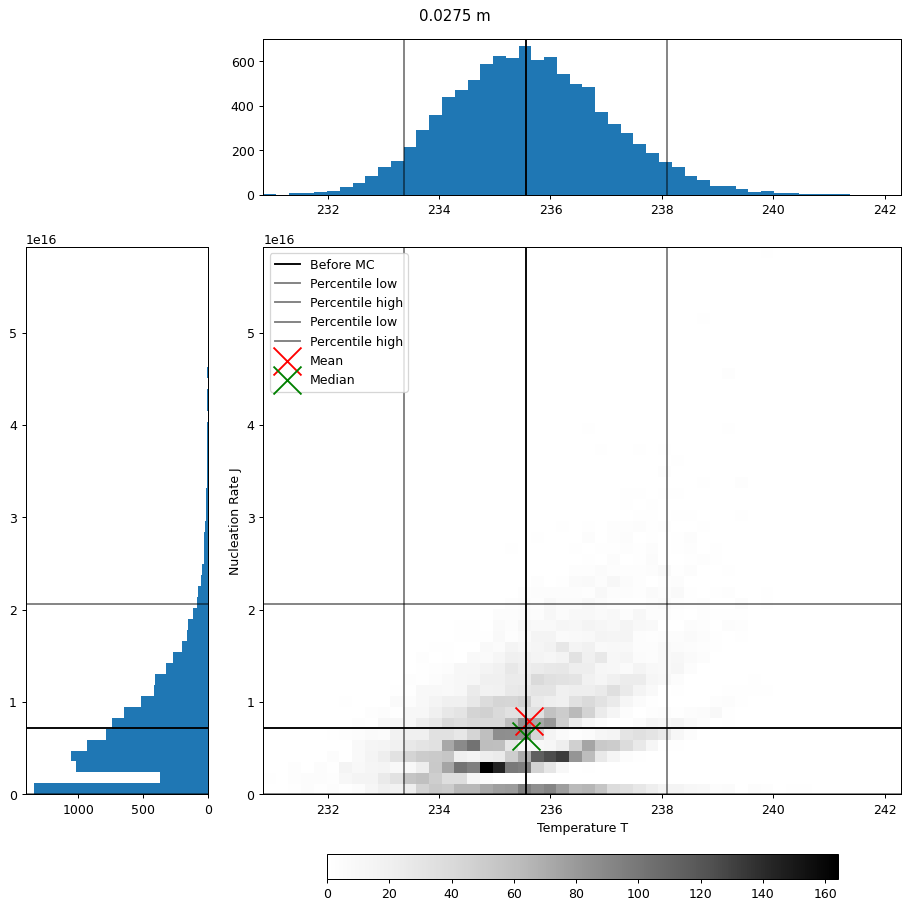

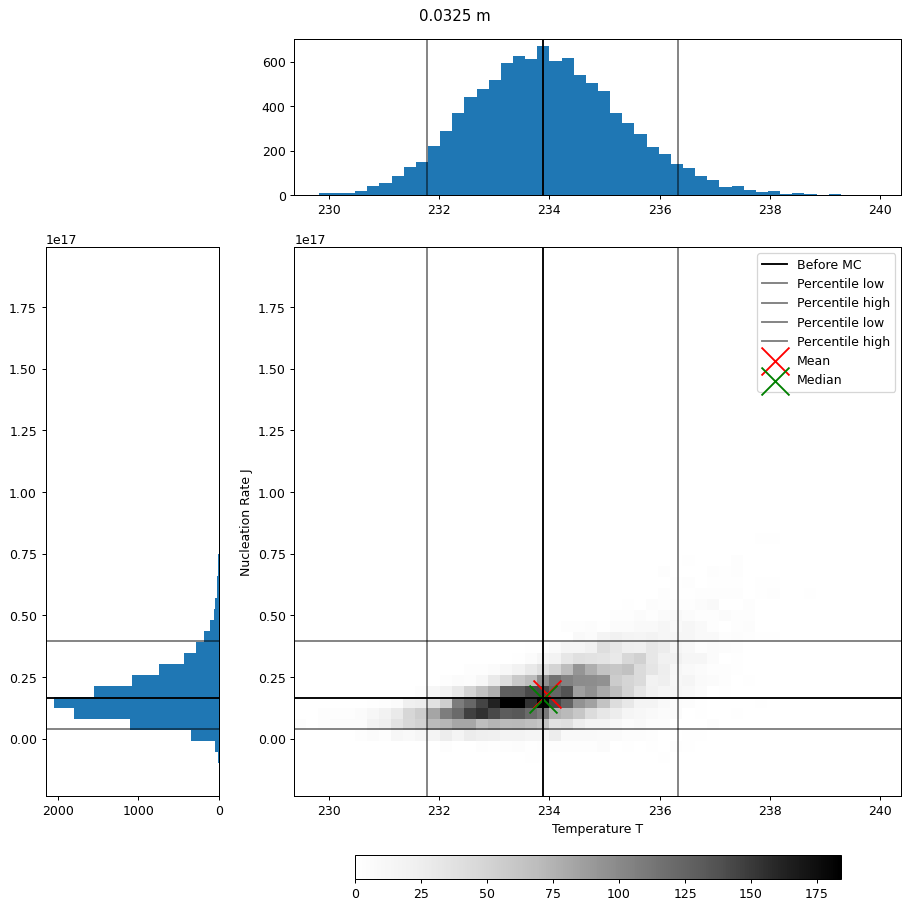

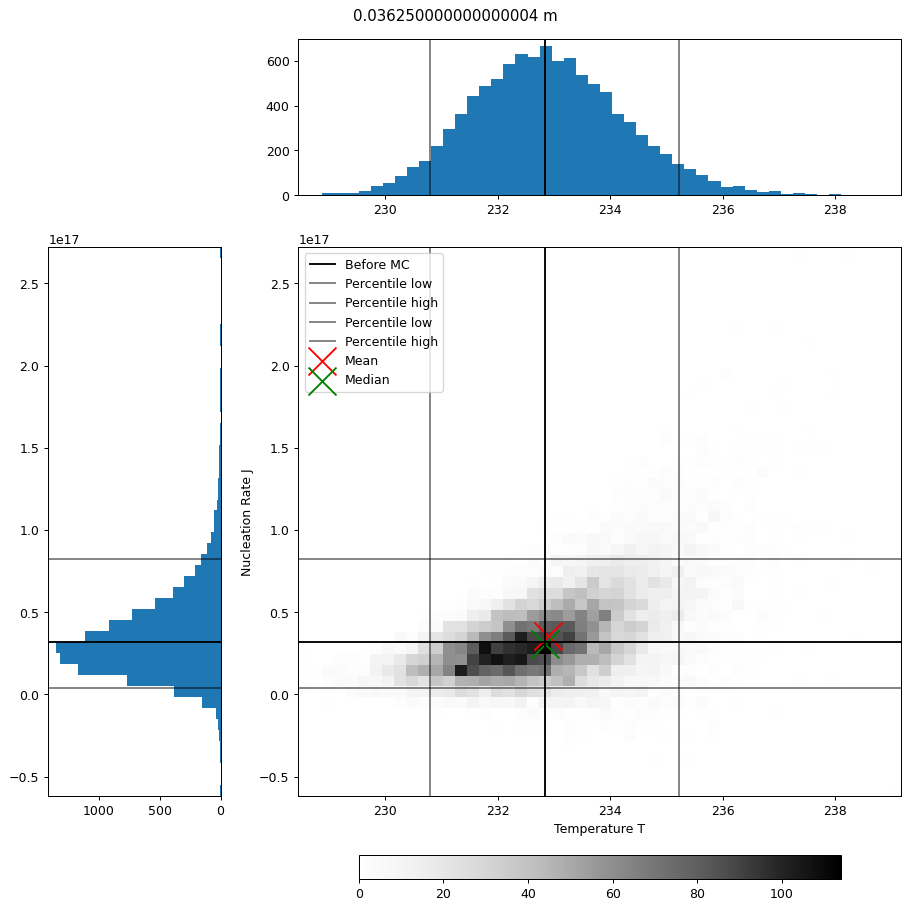

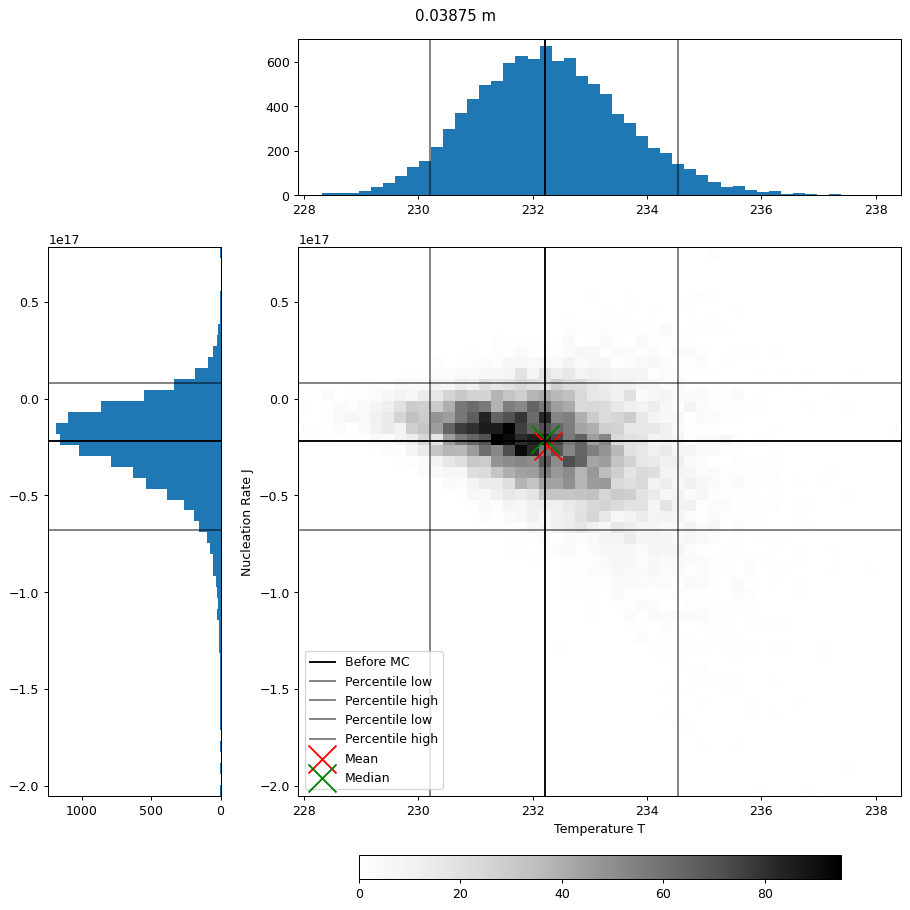

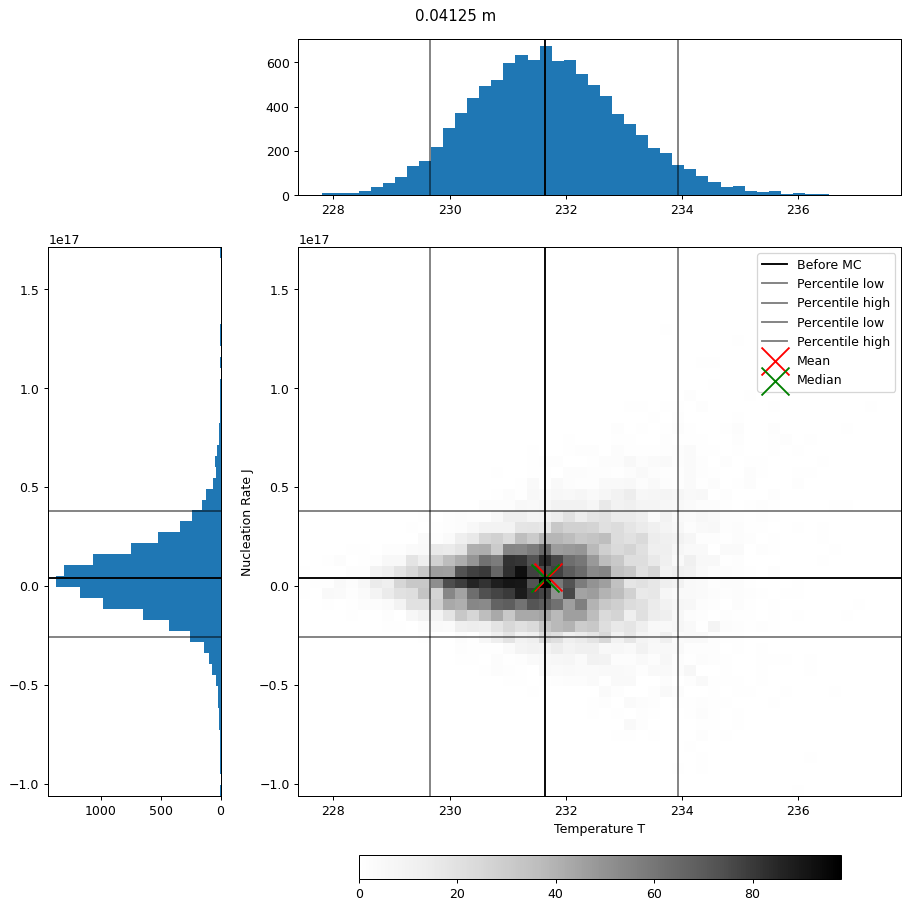

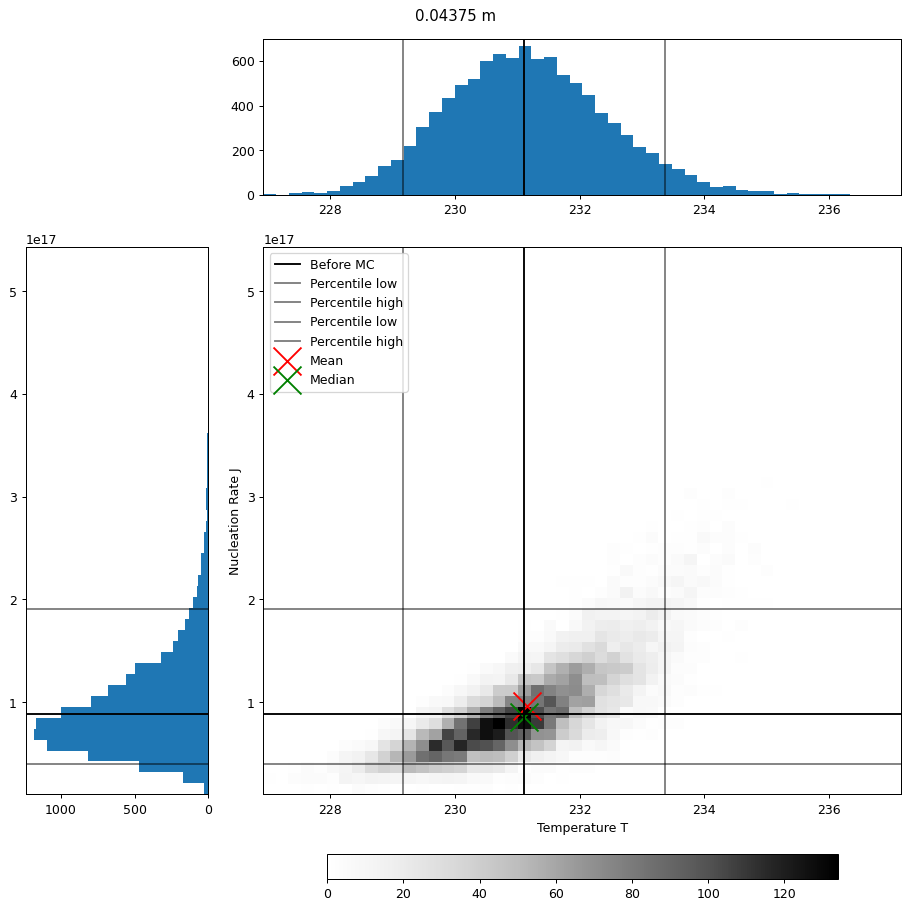

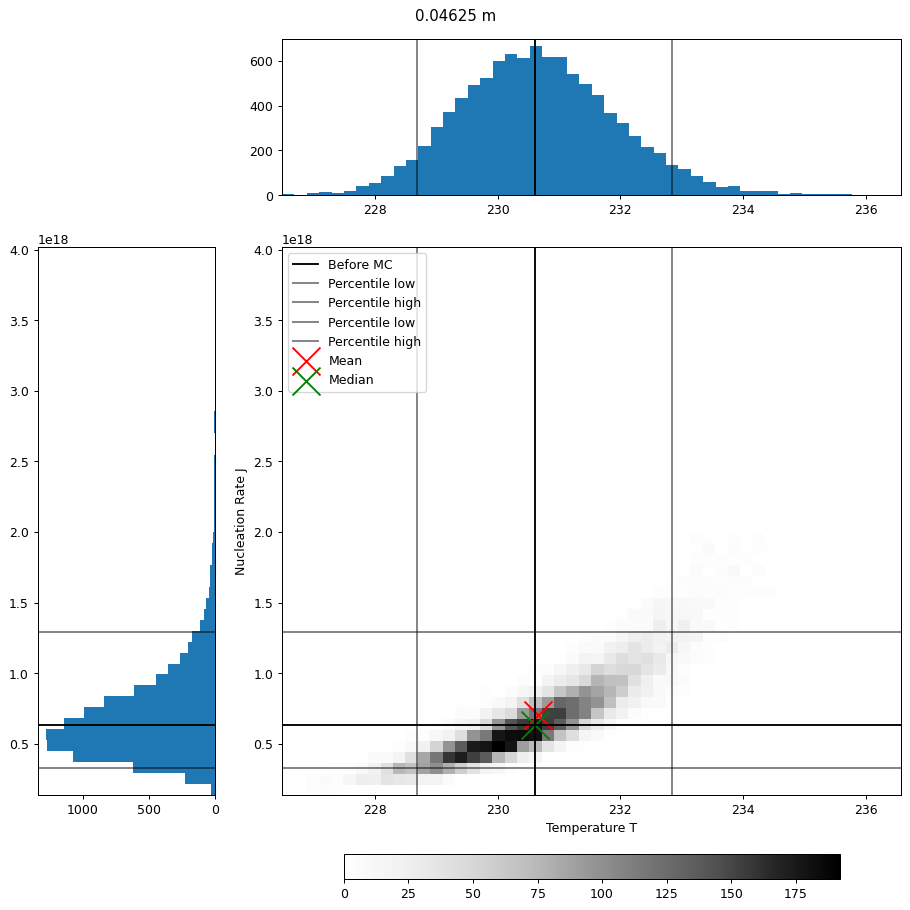

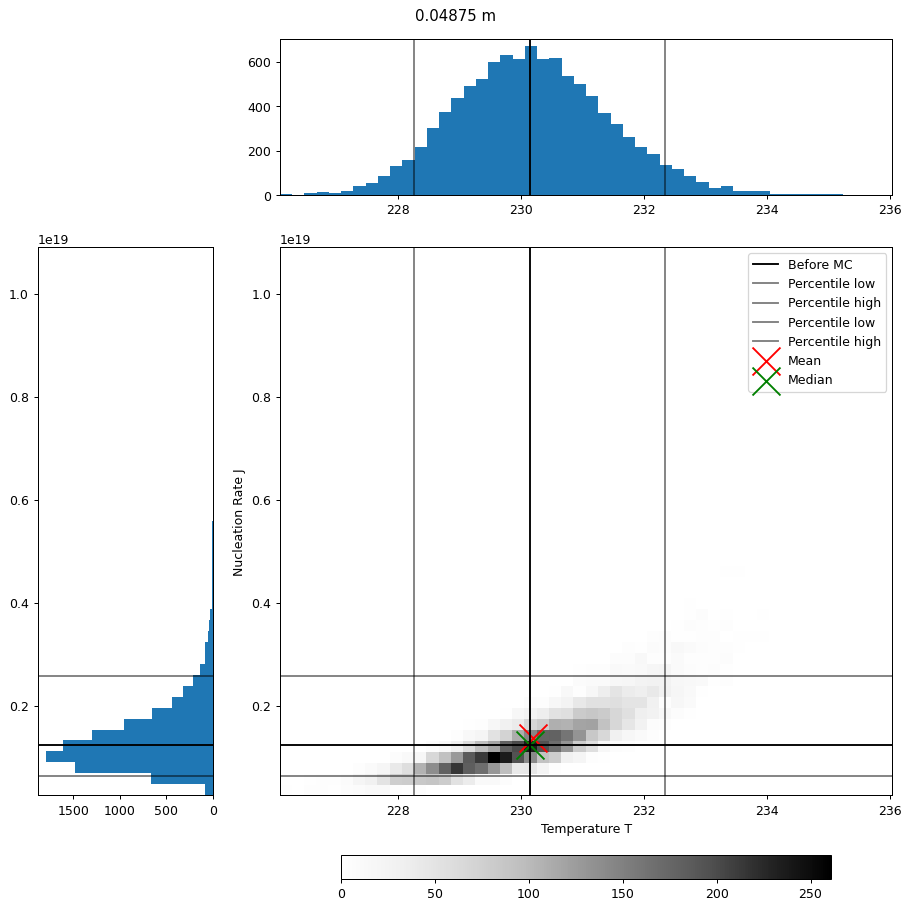

In [118]:

series=mar12

#bin_sizes=[10,20,50,100,200]
bin_sizes=[50]
positions=range(len(series.calculated_distances))
#positions=[6]

for position in positions:
    for bin_size in bin_sizes:
        x=series.T_MC_matrix[:,position]
        y=series.J_MC_matrix[:,position]
        x_bins=bin_size
        y_bins=bin_size

        fig=plt.figure(figsize=[10,10],dpi=90,constrained_layout=True)
        axd=fig.subplot_mosaic([['.', 'histx'], ['histy', 'scat']],
                                 gridspec_kw={'width_ratios': [2, 7],
                                              'height_ratios': [2, 7]})

        axd['histx'].sharex(axd['scat'])
        axd['histy'].sharey(axd['scat'])
        axd['histy'].invert_xaxis()


        _,_,_,im=axd['scat'].hist2d(x,y,cmap='Greys',bins=(x_bins,y_bins))
        axd['scat'].scatter(x,y,s=0.1,marker='.',c='red',alpha=0)

        fig.colorbar(im, orientation='horizontal', ax=axd['scat'], shrink=0.8)

        axd['histx'].hist(x,bins=x_bins)
        axd['histy'].hist(y, orientation='horizontal',bins=y_bins)



        linekwargs={'color':'black'}
        axd['scat'].axhline(series.ideal_J[position],**linekwargs,label='Before MC')
        axd['histy'].axhline(series.ideal_J[position],**linekwargs)
        axd['scat'].axvline(series.ideal_T_at_calculated[position],**linekwargs)
        axd['histx'].axvline(series.ideal_T_at_calculated[position],**linekwargs)

        '''
        J
        '''
        
        linekwargs={'color':'black','alpha':0.5}
        axd['scat'].axhline(series.low_J[position],**linekwargs,label='Percentile low')
        axd['histy'].axhline(series.low_J[position],**linekwargs)
        
        linekwargs={'color':'black','alpha':0.5}
        axd['scat'].axhline(series.high_J[position],**linekwargs,label='Percentile high')
        axd['histy'].axhline(series.high_J[position],**linekwargs)
        
        '''
        T
        '''
        
        linekwargs={'color':'black','alpha':0.5}
        axd['scat'].axvline(series.low_T[position],**linekwargs,label='Percentile low')
        axd['histx'].axvline(series.low_T[position],**linekwargs)
        
        linekwargs={'color':'black','alpha':0.5}
        axd['scat'].axvline(series.high_T[position],**linekwargs,label='Percentile high')
        axd['histx'].axvline(series.high_T[position],**linekwargs)

        

        axd['scat'].set_ylabel('Nucleation Rate J')
        axd['scat'].set_xlabel('Temperature T')

        
        
        mean_x=np.mean(x)
        mean_y=np.mean(y)
        axd['scat'].scatter(mean_x,mean_y,marker='x',c='red',s=500,label='Mean')
        median_x=np.median(x)
        median_y=np.median(y)
        axd['scat'].scatter(median_x,median_y,marker='x',c='green',s=500,label='Median')
        
        axd['scat'].legend()
        fig.suptitle(str(series.calculated_distances[position]) + ' m')


In [130]:


dec7 = Series('Dec 7', interpolate_T)
counts = np.multiply([633, 566, 298, 325], 1)
fractions = [0.0458, 0.362, 0.987, 0.99999]  # ice fraction for focused
distances = np.multiply([40, 45, 47.5, 50], 0.001)  # in m

dec7.set_observables(frequency=398,
                     d_value=18.145e-6,
                     d_sigma=0.409e-6,
                     s_value=38.676e-6,
                     s_sigma=4.063e-6,
                     q_value=57.5,
                     distances=distances[:3],
                     counts=counts[:3],
                     fractions=fractions[:3])

# This is with the last half cutout, when the pressure dropped.
nov3 = Series('Nov 3', interpolate_T)

counts = np.multiply([48, 27, 34, 210, 715, 881, 797, 84], 1)
fractions = [0, 0.03, 0.00, 0.06, 0.04, 0.04,
             0.13, 0.35]  # ice fraction for focused
distances = np.multiply([15, 20, 25, 30, 35, 40, 45, 50], 0.001)  # in m

nov3.set_observables(d_value=20.2e-6,
                     d_sigma=0.496e-6,
                     s_value=58.3e-6,
                     s_sigma=3.67e-6,
                     q_value=56.5,
                     distances=distances[4:],
                     counts=counts[4:],
                     fractions=fractions[4:])

mar12 = Series('Mar 12', interpolate_T)
'''
Data from https://docs.google.com/spreadsheets/d/11-GYikog0r1H5IH8vmNHlBlmi4fgEX_WUqMD0C2dIpY/edit#gid=0
and from https://docs.google.com/spreadsheets/d/1VOADjIf649fGTbqI5R4Td48dqzSHE5dx0zcEj2TWAcc/edit#gid=2063575402
'''
counts = np.multiply([158, 113, 471, 319, 406, 327, 454, 206, 220], 1)
fractions = [0, 0.01769911504, 0.05732484076, 0.09404388715, 0.06896551724,
             0.07339449541, 0.1696035242, 0.6213592233, 0.9181818182]  # ice fraction for focused
distances = np.multiply(
    [25, 30, 35, 37.5, 40, 42.5, 45, 47.5, 50], 0.001)  # in m
mar12.set_observables(d_value=21.44656962e-6,
                      d_sigma=1.400e-6,
                      s_value=58.3e-6,
                      s_sigma=3.67e-6,
                      q_value=55.1,
                      distances=distances[4:],
                      counts=counts[4:],
                      fractions=fractions[4:])


experiments = [dec7, mar12, nov3]
# experiments=[dec7]
for series in experiments:
    series.calculate_errors(percentile=5, do_J=True, trials=5000)
    series.generate_plotting_label()


# LAKSMONO
laksmono12 = Series('Laksmono 12um')
laksmono12.measured_distances = np.multiply([30.60, 40.40, 45.60, 50.63], 1e-3)
laksmono12.calculated_distances = np.multiply([35.50, 43, 48.12], 1e-3)
laksmono12.ideal_T_at_measured = [232.03, 228.81, 227.58, 226.57]
laksmono12.ideal_T_at_calculated = [230.42, 228.19, 227.08]
laksmono12.low_T_err = [1, 1, 1]
laksmono12.high_T_err = [2, 2, 2]
laksmono12.low_T_err_at_measured = [0.10, 1.00, 1.00, 1.00]
laksmono12.high_T_err_at_measured = [2, 2, 2, 2]
laksmono12.ideal_J = np.multiply([2.11E+11, 3.22E+12, 3.58E+12], 1e6)
laksmono12.low_J_err = np.multiply([1.38E+11, 7.90E+11, 2.79E+12], 1e6)
laksmono12.high_J_err = np.multiply([3.12E+12, 4.60E+13, 5.76E+13], 1e6)
laksmono12.plot_label = 'Laksmono 12 um'

laksmono9 = Series('Laksmono 9um')
laksmono9.measured_distances = np.multiply([25.88, 36.04, 46.09], 1e-3)
laksmono9.calculated_distances = np.multiply([30.96, 41.07], 1e-3)
laksmono9.ideal_T_at_measured = [233.36, 230.23, 228.10]
laksmono9.ideal_T_at_calculated = [231.79, 229.16]
laksmono9.low_T_err = [1, 1]
laksmono9.high_T_err = [2, 2]
laksmono9.low_T_err_at_measured = [1.00, 1.00, 1.00]
laksmono9.high_T_err_at_measured = [2, 2, 2]
laksmono9.ideal_J = np.multiply([2.69E+11, 8.45E+11], 1e6)
laksmono9.low_J_err = np.multiply([3.90E+10, 3.71E+11], 1e6)
laksmono9.high_J_err = np.multiply([3.81E+12, 1.22E+13], 1e6)
laksmono9.plot_label = 'Laksmono 9 um'

experiments.extend([laksmono9, laksmono12])


mar12.plot_kwargs = {'color': 'darkblue', 'marker': '^'}
nov3.plot_kwargs = {'color': 'blue', 'marker': 'o'}
dec7.plot_kwargs = {'color': 'teal', 'marker': 'x'}
laksmono12.plot_kwargs = {'color': 'red', 'marker': 's'}
laksmono9.plot_kwargs = {'color': 'darkorange', 'marker': 'D'}

plt.close('all')
plt.figure('T vs distance')
J_vs_distance_ax = plt.gca()
for series in experiments:
    series.plot_T_vs_measured_distance(
        ax=J_vs_distance_ax, label=series.plot_label)

J_vs_distance_ax.set_ylabel('J [1/s*m^3]')
J_vs_distance_ax.set_xlabel('Distance [m]')
J_vs_distance_ax.legend()

plt.figure('J vs T')
J_vs_T_ax = plt.gca()
for series in experiments:
    series.plot_J_vs_T(ax=J_vs_T_ax, label=series.plot_label)

J_vs_T_ax.set_ylabel('J [1/s*m^3]')
J_vs_T_ax.set_xlabel('Temperature [K]')
J_vs_T_ax.legend()

plt.figure('J vs T log', dpi=90, figsize=[8, 8])
J_vs_T_ax_log = plt.gca()
for series in experiments:
    series.plot_J_vs_T(
        ax=J_vs_T_ax_log, label=series.plot_label, **series.plot_kwargs)
    # J_vs_T_ax_log.scatter(series.T_MC_matrix.flatten(),series.J_MC_matrix.flatten(),alpha=0.1)


linthresh = 5e15
J_vs_T_ax_log.set_yscale('symlog', linthresh=linthresh,
                         linscale=0.1, subs=[2, 3, 4, 5, 6, 7, 8, 9])
J_vs_T_ax_log.set_ylabel('J [1/s*m^3]')
J_vs_T_ax_log.set_xlabel('Temperature [K]')
J_vs_T_ax_log.legend()
J_vs_T_ax_log.fill_between(J_vs_T_ax_log.get_xlim(
), y1=[-linthresh, -linthresh], y2=[linthresh, linthresh], color='gray')

plt.savefig('Publication_J_vs_T_cheating.pdf')

<ipython-input-122-3f6b00d25c0d>:127: RuntimeWarning: divide by zero encountered in true_divide
  the_log = np.log(np.divide(np.subtract(1, f_2), np.subtract(1, f_1)))


In [81]:
J_vs_T_ax_log.get_xlim()

(225.20424310717806, 244.47089474926088)

In [4]:
plt.figure()
plt.plot(nov_series.ideal_t_at_measured,
         nov_series.fractions, alpha=1, marker='.')

In [5]:


counts = np.multiply([100, 100, 100, 100], 1)
fractions = [0.1, 0.2, 0.4, 0.8]  # ice fraction for focused
distances = np.multiply([30, 40, 50, 60], 0.001)  # in m

In [6]:


first = Series('11.51', interpolate_T)


first.set_observables(d_value=20.094e-6,
                      d_sigma=0.33e-6,
                      s_value=51.2878e-6,
                      s_sigma=8.473e-6,
                      q_value=54.7,
                      distances=distances,
                      counts=counts,
                      fractions=fractions)

second = Series('13.30', interpolate_T)


second.set_observables(d_value=20.408e-6,
                       d_sigma=1.429e-6,
                       s_value=51.913e-6,
                       s_sigma=17.861e-6,
                       q_value=54.5,
                       distances=distances,
                       counts=counts,
                       fractions=fractions)

third = Series('270 Hz', interpolate_T)


third.set_observables(d_value=20.37e-6,
                      d_sigma=0.347e-6,
                      s_value=51.51e-6,
                      s_sigma=9.98e-6,
                      q_value=54.6,
                      distances=distances,
                      counts=counts,
                      fractions=fractions)

fourth = Series('14.44', interpolate_T)


fourth.set_observables(d_value=18.41e-6,
                       d_sigma=0.443e-6,
                       s_value=40.868e-6,
                       s_sigma=7.271e-6,
                       q_value=61.4,
                       distances=distances,
                       counts=counts,
                       fractions=fractions)

nov17 = [first, second, third, fourth]
# nov17=[third,fourth]

plt.figure()
ax = plt.gca()

for series in nov17:
    print(series.date)
    series.calculate_errors(percentile=5, do_J=False)
    # ax.scatter(nov_series.T_MC_matrix.flatten(),nov_series.J_MC_matrix.flatten(),alpha=1,marker='.')
    series.generate_plotting_label()
    series.plot_measured_T_vs_t(ax=ax, label=series.plot_label)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Temperature [K]')
ax.legend()

11.51
13.30


/Users/olofjonsson/.virtualenvs/opython/lib/python3.8/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


270 Hz
14.44


In [5]:
first = Series('11.51, 45,48 and 50 mm', interpolate_T)

counts = np.multiply([162, 100, 106], 1)
fractions = [0.4814814815, 0.88, 0.984375]  # ice fraction for focused
distances = np.multiply([45, 48, 50], 0.001)  # in m


first.set_observables(frequency=273.2,
                      d_value=20.094e-6,
                      d_sigma=0.33e-6,
                      s_value=51.2878e-6,
                      s_sigma=8.473e-6,
                      q_value=54.7,
                      distances=distances,
                      counts=counts,
                      fractions=fractions)

counts = np.multiply([162, 106], 1)
fractions = [0.4814814815, 0.984375]  # ice fraction for focused
distances = np.multiply([45, 50], 0.001)  # in m

second = Series('11.51, 45 and 50 mm', interpolate_T)

second.set_observables(frequency=273.2,
                       d_value=20.094e-6,
                       d_sigma=0.33e-6,
                       s_value=51.2878e-6,
                       s_sigma=8.473e-6,
                       q_value=54.7,
                       distances=distances,
                       counts=counts,
                       fractions=fractions)

nov17_J = [first, second]

plt.figure()
ax = plt.gca()
for series in nov17_J:
    print(series.date)
    series.calculate_errors(percentile=5, do_J=True, trials=10000)
    # ax.scatter(nov_series.T_MC_matrix.flatten(),nov_series.J_MC_matrix.flatten(),alpha=1,marker='.')
    series.generate_plotting_label()
    series.plot_measured_T_vs_t(ax=ax, label=series.plot_label)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Temperature [K]')
ax.legend()

plt.figure()
ax = plt.gca()

for series in nov17_J:
    print(series.date)
    # ax.scatter(nov_series.T_MC_matrix.flatten(),nov_series.J_MC_matrix.flatten(),alpha=1,marker='.')
    series.generate_plotting_label()
    series.plot_J_vs_T(ax=ax, label=series.plot_label)
    ax.scatter(series.T_MC_matrix.flatten(),
               series.J_MC_matrix.flatten(), alpha=0.1)

ax.set_ylabel('J [1/s*m^3]')
ax.set_xlabel('Temperature [K]')
ax.legend()

11.51, 45,48 and 50 mm


<ipython-input-3-990ad163ce38>:127: RuntimeWarning: divide by zero encountered in true_divide
  the_log = np.log(np.divide(np.subtract(1, f_2), np.subtract(1, f_1)))
/Users/olofjonsson/.virtualenvs/opython/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


11.51, 45 and 50 mm
11.51, 45,48 and 50 mm
11.51, 45 and 50 mm


In [6]:
first = Series('Dec 7', interpolate_T)

counts = np.multiply([633, 566, 298, 325], 1)
fractions = [0.0458, 0.362, 0.987, 0.99999]  # ice fraction for focused
distances = np.multiply([40, 45, 47.5, 50], 0.001)  # in m

first.set_observables(frequency=398,
                      d_value=18.145e-6,
                      d_sigma=0.409e-6,
                      s_value=38.676e-6,
                      s_sigma=4.063e-6,
                      q_value=57.5,
                      distances=distances,
                      counts=counts,
                      fractions=fractions)

dec_7 = [first]

for series in dec_7:
    series.calculate_errors(percentile=5, do_J=True, trials=10000)

plt.figure()
ax = plt.gca()
for series in dec_7:
    print(series.date)
    # ax.scatter(nov_series.T_MC_matrix.flatten(),nov_series.J_MC_matrix.flatten(),alpha=1,marker='.')
    series.generate_plotting_label()
    series.plot_T_vs_measured_distance(ax=ax, label=series.plot_label)

ax.set_xlabel('Distance [m]')
ax.set_ylabel('Temperature [K]')
ax.legend()

plt.figure('J_plot')
J_ax = plt.gca()
for series in dec_7:
    print(series.date)
    # ax.scatter(nov_series.T_MC_matrix.flatten(),nov_series.J_MC_matrix.flatten(),alpha=1,marker='.')
    series.generate_plotting_label()
    series.plot_J_vs_T(ax=J_ax, label=series.plot_label)

J_ax.set_ylabel('J [1/s*m^3]')
J_ax.set_xlabel('Temperature [K]')
J_ax.legend()

plt.figure()
ax = plt.gca()
for series in dec_7:
    print(series.date)
    # ax.scatter(nov_series.T_MC_matrix.flatten(),nov_series.J_MC_matrix.flatten(),alpha=1,marker='.')
    series.generate_plotting_label()
    series.plot_J_vs_distance(ax=ax, label=series.plot_label)

ax.set_ylabel('J [1/s*m^3]')
ax.set_xlabel('Distance [m]')
ax.legend()

<ipython-input-3-990ad163ce38>:127: RuntimeWarning: divide by zero encountered in true_divide
  the_log = np.log(np.divide(np.subtract(1, f_2), np.subtract(1, f_1)))
<ipython-input-3-990ad163ce38>:127: RuntimeWarning: invalid value encountered in true_divide
  the_log = np.log(np.divide(np.subtract(1, f_2), np.subtract(1, f_1)))
<ipython-input-3-990ad163ce38>:127: RuntimeWarning: divide by zero encountered in log
  the_log = np.log(np.divide(np.subtract(1, f_2), np.subtract(1, f_1)))


Dec 7
Dec 7
Dec 7


<ipython-input-3-990ad163ce38>:127: RuntimeWarning: divide by zero encountered in true_divide
  the_log = np.log(np.divide(np.subtract(1, f_2), np.subtract(1, f_1)))
<ipython-input-3-990ad163ce38>:127: RuntimeWarning: invalid value encountered in true_divide
  the_log = np.log(np.divide(np.subtract(1, f_2), np.subtract(1, f_1)))


92

In [54]:
for series in experiments:
    print('.....')
    print(series.calculated_distances)
    print(series.ideal_v)
    print(series.d_value)
    print(series.ideal_t_at_measured)
    print(series.low_t)
    print(series.ideal_t_at_calculated)
    print(series.ideal_J)

print('....')

for series in dec_7:
    print(np.array(series.high_J_err).T)

.....
[0.0425  0.04625 0.04875]
11.84918369331327
1.8145e-05
[0.003375759970922959, 0.003797729967288328, 0.004008714965471013, 0.004219699963653698]
[0.0029807  0.00324371 0.00341904]
[0.003586744969105643, 0.0039032224663796715, 0.0041142074645623555]
[3.04966788431319e+17, 5.89938409389934e+18, 1.086438832370552e+19]
....
[1.10416322e+17 3.28381965e+18            nan]


In [56]:
for series in nov17_J:
    print(series.calculated_distances)
    print(series.ideal_v)
    print(series.d_value)
    print(series.ideal_t_at_measured)
    print(series.low_t)
    print(series.ideal_t_at_calculated)

print('....')

for series in nov17_J:
    print(np.array(series.high_J_err).T)

[0.0465 0.049 ]
11.0065739661808
2.0094e-05
[0.0040884656877125105, 0.004361030066893344, 0.004542739653013899]
[0.00326987 0.00344567]
[0.0042247478773029265, 0.004451884859953622]
[0.0475]
11.0065739661808
2.0094e-05
[0.0040884656877125105, 0.004542739653013899]
[0.0033341]
[0.004315602670363205]
....
[6.90368545e+17            inf]
[inf]


In [150]:
np.std(series.T_MC_matrix_at_measured, axis=0)

/Users/olofjonsson/.virtualenvs/opython/lib/python3.8/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


array([1.57965677, 1.55283422,        nan])

In [97]:
interpolate_T([2.02e-05*1e6, 0.001179175402407865], method='linear')

array([243.91282954])

In [98]:
interpolate_T.grid

(array([ 3,  5, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 array([2.000e-06, 4.000e-06, 6.000e-06, ..., 9.996e-03, 9.998e-03,
        1.000e-02]))

In [99]:
plt.imshow(nov_series.all_t)

In [115]:
plt.scatter(nov_series.all_distances.flatten(), nov_series.all_T.flatten())

In [111]:
np.shape(nov_series.all_t)

(1000, 7)

In [67]:
for distance_i, distance in enumerate(nov_series.measured_distances):
    low = np.percentile(nov_series.T_MC_matrix_at_measured[:, distance_i], q=5)
    mid = nov_series.ideal_T_at_measured[distance_i]
    high = np.percentile(
        nov_series.T_MC_matrix_at_measured[:, distance_i], q=95)

    print('{0:.1f} {1:.1f} {2:.1f}'.format(low, mid, high))

242.3 243.9 245.5
239.0 240.5 242.0
236.6 238.0 239.4
234.8 236.1 237.5
233.3 234.5 235.8
232.0 233.2 234.5
230.9 232.1 233.4
230.0 231.2 232.4


In [74]:

low = np.percentile(nov_series.T_MC_matrix_at_measured, q=5, axis=0)
high = np.percentile(nov_series.T_MC_matrix_at_measured, q=95, axis=0)

#print('{0:.1f} {1:.1f} {2:.1f}'.format(low,mid,high))

In [73]:
low

array([242.33286466, 239.03304815, 236.63159725, 234.76676891,
       233.25849823, 232.00226529, 230.9315207 , 230.00225967])

In [105]:
def binomial_interval(n, p, method='Wald'):
    z = 1.96
    if method == 'Wald':
        error = z*np.sqrt((1.0-p)*p/n)
    elif method == 'Agresti–Coull':
        error = z*np.sqrt((1.0-p)*p/(n+z*z))
    elif method == 'Wilson_upper':
        z = 1.96
        num = p+z*z/(2*n)+z*np.sqrt(p*(1-p)/n+z*z/(4*n*n))
        den = 1+(z*z)/n
        error = np.divide(num, den)
    elif method == 'Wilson_lower':
        z = -1.96
        num = p+z*z/(2*n)+z*np.sqrt(p*(1-p)/n+z*z/(4*n*n))
        den = 1+(z*z)/n
        error = np.divide(num, den)
    else:
        print('Not an implemented method specified')
    return error


print(binomial_interval(162, 0.48, method='Wilson_lower'))
print(binomial_interval(162, 0.48, method='Wilson_upper'))
print(binomial_interval(100, 0.34, method='Wilson_lower'))
print(binomial_interval(100, 0.34, method='Wilson_upper'))

0.4044237100419154
0.556502860854651
0.25461379497543
0.43722454341689065
